# Lecture 6.3: K-Means Clustering

The codes and notes by courtesy of [greyhatguy007](https://github.com/greyhatguy007/Machine-Learning-Specialization-Coursera ) and [Andrew NG](https://www.coursera.org/specializations/machine-learning-introduction).


In this tuorial, we will implement the K-means algorithm and use it for image compression. 

* We will start with a sample dataset that will help us gain an intuition of how the K-means algorithm works. 




<!-- # Outline
- [ 1 - Implementing K-means](#1)
  - [ 1.1 Finding closest centroids](#1.1)
    - [ Exercise 1](#ex01)
  - [ 1.2 Computing centroid means](#1.2)
    - [ Exercise 2](#ex02)
- [ 2 - K-means on a sample dataset ](#2)
- [ 3 - Random initialization](#3)
- [ 4 - Image compression with K-means](#4)
  - [ 4.1 Dataset](#4.1)
  - [ 4.2 K-Means on image pixels](#4.2)
  - [ 4.3 Compress the image](#4.3) -->


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import timeit
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(0)
random.seed(0)

Let's run some useful functions first.

In [2]:
def load_data():
    X = np.load("data/ex6_X.npy")
    return X

def draw_line(p1, p2, style="-k", linewidth=1):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], style, linewidth=linewidth)

def plot_data_points(X, idx):
    # plots data points in X, coloring them so that those with the same
    # index assignments in idx have the same color
    plt.scatter(X[:, 0], X[:, 1], c=idx)
    
def plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i):
    # Plot the examples
    plot_data_points(X, idx)
    
    # Plot the centroids as black 'x's
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k', linewidths=3)
    
    # Plot history of the centroids with lines
    for j in range(centroids.shape[0]):
        draw_line(centroids[j, :], previous_centroids[j, :])
    
    plt.title("Iteration number %d" %i)

<a name="1"></a>
## 1. Implementing K-means

The K-means algorithm is a method to automatically cluster similar
data points together. 

* Concretely, we are given a training set $M$ data points $ \mathcal{D}=\left\{\mathbf{x}^{(i)}\right\}_{i=1}^M, $ where $ \mathbf{x}^{(i)} \in \mathbb{R}^N$, and we want
to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_means(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    * (i) Assigning each training example $\mathbf{x}^{(i)}$ to its closest centroid, and
    * (ii) Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The K-means algorithm will always converge to some final set of means for the centroids. 

* However, that the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

We will implement the two phases of the K-means algorithm separately
in the next sections. 
* We will start by completing `find_closest_centroid` and then proceed to complete `compute_centroids`.

<a name="1.1"></a>
### 1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the
algorithm assigns every training example $\mathbf{x}^{(i)}$ to its closest
centroid, given the current positions of centroids. 


Let's complete the code in `find_closest_centroids`. 
* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` .
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{1,...,K\}$, where $K$ is total number of centroids) to every training example .
* Pick the cluster centers that minimize the squared distance to all its cluster members
$$
\min _{\mathbf{c}_1, \ldots, \mathbf{c}_K} \sum_{i=1}^M\left\|\mathbf{x}^{(i)}-\mathbf{c}_{z^{(i)}}\right\|_2^2 ,
$$
where 
 * $z^{(i)}$ is the index of the centroid that is closest to $\mathbf{x}^{(i)}$ (corresponds to `idx[i]` in the starter code).
 * Let $C_j$ be the set of points assigned to Cluster $j$ :
$$
C_j=\left\{\mathbf{x}^{(i)} \mid z^{(i)}=j\right\},
$$
  cluster center is the mean of the points in that cluster:
$$
\mathbf{c}_j=\frac{1}{\left|C_j\right|} \sum_{\mathbf{x}^{(i)} \in C_j} \mathbf{x}^{(i)}.
$$
  $\mathbf{c}_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code) .

In [3]:
# FUNCTION: find_closest_centroids

def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): k centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K
    K = centroids.shape[0]

    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        # Array to hold distance between X[i] and each centroids[j]
        distance = [] 
        for j in range(centroids.shape[0]):
            norm_ij = np.linalg.norm(X[i] - centroids[j])
            distance.append(norm_ij)
            idx[i] = np.argmin(distance)
    return idx

Now let's check our implementation using an example dataset.

In [4]:
# Load an example dataset that we will be using
X = load_data()

The code below prints the first five elements in the variable `X` and the dimensions of the variable.

In [5]:
print("First five elements of X are:\n", X[:5]) 
print('The shape of X is:', X.shape)

First five elements of X are:
 [[1.84207953 4.6075716 ]
 [5.65858312 4.79996405]
 [6.35257892 3.2908545 ]
 [2.90401653 4.61220411]
 [3.23197916 4.93989405]]
The shape of X is: (300, 2)


In [6]:
# Select an initial set of centroids (3 Centroids)
initial_centroids = np.array([[3,3], [6,2], [8,5]])

# Find closest centroids using initial_centroids
idx = find_closest_centroids(X, initial_centroids)

# Print closest centroids for the first three elements
print("First three elements in idx are:", idx[:3])

First three elements in idx are: [0 2 1]


<a name="1.2"></a>
### 1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the
algorithm recomputes, for each centroid, the mean of the points that
were assigned to it.


The `compute_centroids` below is to recompute the value for each centroid

* Specifically, for every centroid $\mathbf{c}_j$ we set
$$\mathbf{c}_j = \frac{1}{|C_j|} \sum_{i \in C_j} \mathbf{x}^{(i)},$$ 

    where 
    * $C_j$ is the set of examples that are assigned to centroid $j$,
    * $|C_j|$ is the number of examples in the set $C_j$.


* Concretely, if two examples say $\mathbf{x}^{(3)}$ and $\mathbf{x}^{(5)}$ are assigned to centroid $j=2$,
then update $\mathbf{c}_2 = \frac{1}{2}(\mathbf{x}^{(3)}+\mathbf{x}^{(5)})$.

In [7]:
# FUNCTION: compute_centpods

def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape

    centroids = np.zeros((K, n))

    for k in range(K):   
        points = X[idx == k]  
        centroids[k] = np.mean(points, axis = 0)
    
    return centroids

Now try our implementation by running the cell below.

In [8]:
K = 3
centroids = compute_centroids(X, idx, K)

print("The centroids are:", centroids)

The centroids are: [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


<a name="2"></a>
## 2. K-means on a sample dataset 

<a name="2.1"></a>
### 2.1 Implement K-means from scratch

Now we have completed the two functions (`find_closest_centroids`
and `compute_centroids`) above, the next step is to run the
K-means algorithm on a toy 2D dataset. 
* Let's look at the function (`run_kMeans`) below to understand how it works. 
* Notice that the code calls the two functions above in a loop.

When we run the code below, it will produce a
visualization that steps through the progress of the algorithm at
each iteration. 
* At the end, our figure should look like the one displayed in Figure 1.

<img src="images/figure 1.png" width="500" height="500">

In [9]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    
    # Run K-Means
    start_time = timeit.default_timer()
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    elapsed = timeit.default_timer() - start_time
    print("Time elapsed: %.4f s."% elapsed)
    plt.show() 
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Time elapsed: 0.1707 s.


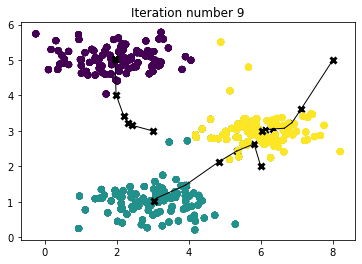

In [10]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])
K = 3

# Number of iterations
max_iters = 10

centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

<a name="2.2"></a>
### 2.2 Random initialization

The initial assignments of centroids for the example dataset was designed so that we will see the same figure as in Figure 1. In practice, a good strategy for initializing the centroids is to select random examples from the
training set.

In this part, let's see how the function `kMeans_init_centroids` is implemented.
* The code first randomly shuffles the indices of the examples (using `np.random.permutation()`). 
* Then, it selects the first $K$ examples based on the random permutation of the indices. 
    * This allows the examples to be selected at random without the risk of selecting the same example twice.

In [11]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-Means on the dataset X
    
    Args:
        X (ndarray): Data points 
        K (int):     number of centroids/clusters
    
    Returns:
        centroids (ndarray): Initialized centroids
    """
    
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    
    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    
    return centroids

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Time elapsed: 0.1545 s.


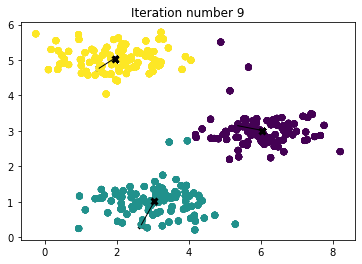

In [12]:
# Run the K-Means algorithm on this data
# Try different values of K and max_iters here
K = 3                       
max_iters = 10               

# Using the function we have implemented above. 
initial_centroids = kMeans_init_centroids(X, K) 

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

<a name="2.3"></a>
### 2.3 Compare with scikit-learn

Try to apply ``KMeans`` from scikit-learn. It's faster!

In [13]:
#Implement k-means clustering to form k clusters
start_time = timeit.default_timer()
kmeans = KMeans(n_clusters=K, init=initial_centroids, max_iter=max_iters)
kmeans.fit(X)
elapsed = timeit.default_timer() - start_time
print("Time elapsed: %.4f s."% elapsed)

Time elapsed: 0.3692 s.


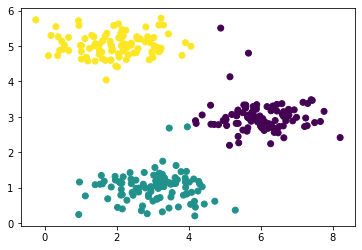

In [14]:
plot_data_points(X, kmeans.labels_)

Let's check if the results are the same.

In [15]:
sum(idx != kmeans.labels_)

0